#### 作品三：分類器評比 -- 紅酒
##### 姓名：嚴潔翎
##### 學號：410878043
##### 目標：利用三份資料，比較不同分類器之表現，並觀察各別對資料做 PCA 後的分類結果，是優於或劣於原始資料。分類器包含三種：邏輯斯迴歸 (Logistic Regression)、支援向量機 (SVM) 及神經網路 (Neural Network)。內部參數是決定分類器重要的螺絲，這些參數都能優化模型，使模型在所有訓練數據上的平均損失最小化，而此作品除了比較不同資料帶來的影響外，更透過調整內部參數，達到最佳的分類效果。

<hr>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from numpy.linalg import eig
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
plt.style.use('default')

【資料簡述】此資料為義大利 3 個紅酒製造商所產製的紅酒，包括 178 支紅酒的 13 種化學成分。

【分類方法】
1. Logistic Regression
2. SVM
3. Neural Network

【資料處理】
1. 切割資料集：將資料集以 3 : 1 ( 75 % : 25 % ) 分成訓練集、測試集，
2. 標準化：分別對訓練集、測試集標準化，避免因單位不同、數值大小差距過大而造成的分析錯誤。
3. 主成分分析：比較使用「原始資料」與「PCA 後萃取出的資訊」的差異。

In [2]:
# only excecute this cell once, cuz the comparison among different learner must based on same training/testing dataset
df = pd.read_excel('wine.xlsx')
X = np.array(df.iloc[:, :-1]) # 排除最後一欄標籤 N*p, hw2 is p*N
y = np.array(df.iloc[:, -1])

# Split data into training and testing data
ratio = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ratio)    

# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

print("# of obs.: ", X.shape[0])
print("# of variables: ", X.shape[1])
print("# of groups: ", len(np.unique(y)))

# of obs.:  178
# of variables:  13
# of groups:  3


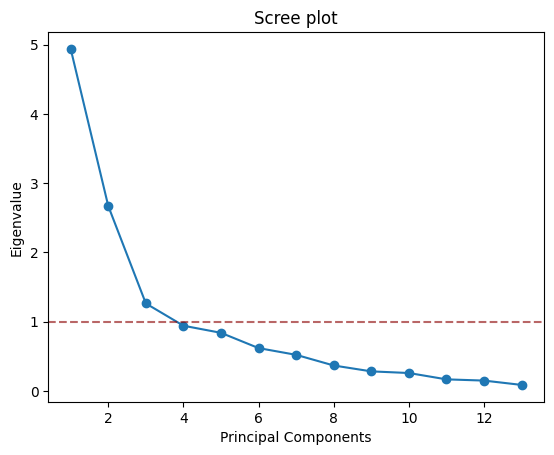

In [34]:
Sx = np.cov(X_train_.T, bias = False)
w, v = eig(Sx)
idx = np.argsort(w)[::-1]
eigvals = w[idx]
eigvecs = v[:, idx] 
Sigma_x = eigvecs @ np.diag(eigvals) @ eigvecs.T

x = np.arange(1, 1 + len(eigvals))
plt.plot(x, eigvals, marker='o')
plt.axhline(1, c = 'darkred', ls = '--', alpha = 0.6)
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalue')
plt.title('Scree plot')

In [115]:
pca = PCA(n_components = 3).fit(X_train_)
Z_train = pca.transform(X_train_)   # Apply dimensionality reduction to X.
Z_test = pca.transform(X_test_)
# ----------------------------------------------------
explained = np.round(pca.explained_variance_ratio_*100, 2)
print('Explained variance ratio: {}%'.format("%, ".join(str(x) for x in explained)))
print('Cummulative varianceexplained : {:.2%}'.format(round(sum(pca.explained_variance_ratio_), 4)))

Explained variance ratio: 36.57%, 19.53%, 10.37%
Cummulative varianceexplained : 66.47%


【討論】
雖然前三個主成分的所解釋的總變異量不高，約 $66.5\%$ 左右，但從陡坡圖來看，其特徵值均大於 1，而其餘主成分所解釋的總變異量差距不大，所只取前三個主成分作為 PCA 資料。

<hr>

## 邏輯斯迴歸

【參數調整】solver
- lbfgs
- liblinear
- newton-cg

【參與資料】
- 原始資料
- 標準化資料
- PCA 資料

### 原始資料

In [33]:
%%time

# 未標準化
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose = 0)
# sol = 'lbfgs' # 'lbfgs' is the default
sol = 'liblinear'
# sol = 'newton-cg'
clf_LR_ori = LogisticRegression(solver = sol, **opts)    # define learner
clf_LR_ori.fit(X_train, y_train)                           # start training, learned
y_pred = clf_LR_ori.predict(X_test)  

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.93      0.88      0.90        16
           2       0.89      0.89      0.89        19
           3       0.91      1.00      0.95        10

    accuracy                           0.91        45
   macro avg       0.91      0.92      0.92        45
weighted avg       0.91      0.91      0.91        45

CPU times: total: 0 ns
Wall time: 10 ms


### 標準化資料

In [35]:
%%time 

# 標準化
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose = 0)
sol = 'liblinear'   
clf_LR_original = LogisticRegression(solver = sol, **opts)    
clf_LR_original.fit(X_train_, y_train)                           
y_pred = clf_LR_original.predict(X_test_)  

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.94      1.00      0.97        16
           2       1.00      0.95      0.97        19
           3       1.00      1.00      1.00        10

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

CPU times: total: 0 ns
Wall time: 9.53 ms


### PCA 資料

In [36]:
%%time

# PCA
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=0)
solver = 'liblinear'
clf_LR_pca = LogisticRegression(solver = solver, **opts)
clf_LR_pca.fit(Z_train, y_train)
y_pred = clf_LR_pca.predict(Z_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.94      0.91        16
           2       0.94      0.89      0.92        19
           3       1.00      1.00      1.00        10

    accuracy                           0.93        45
   macro avg       0.94      0.94      0.94        45
weighted avg       0.93      0.93      0.93        45

CPU times: total: 0 ns
Wall time: 9.5 ms


【討論】

- 從肉眼無法分辨不同 solver 或不同資料的運行時間，但透過 `%%time` 可以明顯看出時間差，不過三者時間其實沒有差很多，只有準確率有明顯差距。而試了三種 solver: (1) lbfgs, (2) liblinear, (3) newton-cg 以 solver = liblinear 的速度是最快的，因 liblinear 適合較小的資料集。

- 比較三者準確率
    - 未標準化：91 %
    - 標準化：96 %
    - PCA：93 %

    此結果非常合理，「未標準化」與「標準化」後的資料準確率差了 5 %，而「主成分資料」的準確率介在兩者之間，因為 PCA 只用到部分資訊，所以自然低於使用所有資料的準確率。

<hr>

## SVM

【參數組合】
- kernel: linear, rbf, poly, sigmoid，共四種
- gamma: scale, auto，共兩種
- decision_function_shape: ovo, ovr，共兩種

【參與資料】
- 標準化
- PCA


In [22]:
para = {'kernel':('linear','rbf','poly','sigmoid'), 'gamma':('scale','auto'), \
    'decision_function_shape':('ovo','ovr')}
svc = SVC(tol = 1e-6, max_iter = int(1e6))
clf = GridSearchCV(svc, para, cv = 10)   # default: 5-fold
clf.fit(X_train_, y_train)
# clf.cv_results_
print(f"# of folds: {clf.n_splits_}")
print(f"Mean cross-validated score of the best_estimator: {clf.best_score_:.2%}")
print(f"best combination: {clf.best_params_}", end = "\n\n")

# of folds: 10
Mean cross-validated score of the best_estimator: 99.23%
best combination: {'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}



In [ ]:
df = pd.DataFrame(clf.cv_results_)[['param_decision_function_shape','param_gamma','param_kernel','mean_fit_time','mean_test_score']]
df.sort_values(by=['mean_test_score'], ascending = False)

【討論】

尋找最佳學習器時需要比較各個參數組合的結果，若利用迴圈，讓每一種組合依序執行，而此處用到 `sklearn.model_selection` 的 `GridSearchSV`，除了能找到最佳參數組合外，能同步進行節省時間，還能進行交叉驗證，避免單次執行的結果較特殊，造成推斷偏誤。


根據上述結果，在 16 種 SVM 參數組合中，從 `best_params_` 得到的結果為：
- kernel: rbf
- gamma: scale
- decision_funciton_shape: ovo


### 標準化資料

In [59]:
%%time
# standardized
opts = dict(decision_function_shape = 'ovo', \
               tol = 1e-6, max_iter = int(1e6))
clf_svm_ori = SVC(kernel = "rbf", gamma = 'scale', **opts)     
clf_svm_ori.fit(X_train_, y_train)
predictions = clf_svm_ori.predict(X_test_)
print(f"{clf_svm_ori.score(X_test_, y_test):.2%}\n")   # test score
print(classification_report(y_test, predictions))


97.78%

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      0.95      0.97        19
           3       0.91      1.00      0.95        10

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

CPU times: total: 0 ns
Wall time: 14.7 ms


### PCA 資料

In [60]:
%%time
# pca
opts = dict(decision_function_shape = 'ovo', \
               tol = 1e-6, max_iter = int(1e6))
clf_svm_ori = SVC(kernel = 'rbf', gamma = 'scale',**opts)     
clf_svm_ori.fit(Z_train, y_train)
predictions = clf_svm_ori.predict(Z_test)
print(f"{clf_svm_ori.score(Z_test, y_test):.2%}\n")   # test score
print(classification_report(y_test, predictions))


95.56%

              precision    recall  f1-score   support

           1       1.00      0.94      0.97        16
           2       0.95      0.95      0.95        19
           3       0.91      1.00      0.95        10

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45

CPU times: total: 0 ns
Wall time: 19.9 ms


## 神經網路


激活函數 (activation function)：神經網路在訓練時，會以線性模式求解，但大部分的實際問題為非線性，激活函數的引入能讓分析結果更準確。

> - 在類神經網路中如果不使用激勵函數，那麼在類神經網路中皆是以上層輸入的線性組合作為這一層的輸出（也就是矩陣相乘），輸出和輸入依然脫離不了線性關係，做深度類神經網路便失去意義。
https://ithelp.ithome.com.tw/articles/10237036?sc=rss.iron 

> - Defines how the weighted sum of the input is transformed into an output from a node or nodes in a layer of the network. 

簡單來說，就是要決定將哪個激活函數放在隱藏層，能讓結果及效率達到目標。

【參數組合】
- solver: lbfgs, sgd, adam
- activation: identity, relu, logistic
- hidden layer: (20, ), (50, ), (80, ), (100, ), (40, 40), (50, 50)

【參與資料】
- 標準化
- PCA

In [42]:
para = {'solver':('lbfgs','sgd','adam'), 'activation':('identity','logistic','relu'), \
    'hidden_layer_sizes':((20,), (50,), (80,), (100,), (40, 40), (50, 50))}
mlp = MLPClassifier(tol = 1e-6, max_iter = int(1e6))
clf_mlp = GridSearchCV(mlp, para, cv = 10)   # default: 5-fold
clf_mlp.fit(X_train_, y_train)

print(f"# of folds: {clf_mlp.n_splits_}")
print(f"Mean cross-validated score of the best_estimator: {clf_mlp.best_score_:.2%}")
print(f"best combination: {clf_mlp.best_params_}", end = "\n\n")

# of folds: 10
Mean cross-validated score of the best_estimator: 100.00%
best combination: {'activation': 'identity', 'hidden_layer_sizes': (50,), 'solver': 'sgd'}



【討論】
從眾多組合當中，透過 GridSearchCV 測試每個參數組合所找到的最佳組合如下：
- activation: identity
- hidden layer size: (50, )
- solver: sgd


- SGD 特點：
    - 提升訓練速度
    

### 標準化資料

In [47]:
%%time

hidden_layers = (50,)    
activation = 'identity'   
opts = dict(hidden_layer_sizes = hidden_layers, \
        activation = activation, tol = 1e-6, max_iter = int(1e6), warm_start=True)
solver = 'sgd' 
clf_MLP_ori = MLPClassifier(solver = solver, **opts)
clf_MLP_ori.fit(X_train_, y_train)
predictions = clf_MLP_ori.predict(X_test_)

print(f"{clf_MLP_ori.score(X_test_, y_test):.2%}\n")
print(classification_report(y_test, predictions))

93.33%

              precision    recall  f1-score   support

           1       1.00      0.94      0.97        16
           2       0.94      0.89      0.92        19
           3       0.83      1.00      0.91        10

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45

CPU times: total: 2.14 s
Wall time: 6.05 s


### PCA 資料

In [49]:
%%time

# PCA
hidden_layers = (50,)    
activation = 'identity'   
opts = dict(hidden_layer_sizes = hidden_layers, \
        activation = activation, tol = 1e-6, max_iter = int(1e6), warm_start=True)
solver = 'sgd'   
clf_MLP_pca = MLPClassifier(solver = solver, **opts)
clf_MLP_pca.fit(Z_train, y_train)
predictions = clf_MLP_pca.predict(Z_test)

print(f"{clf_MLP_pca.score(Z_test, y_test):.2%}\n")
print(classification_report(y_test, predictions))

91.11%

              precision    recall  f1-score   support

           1       1.00      0.88      0.93        16
           2       0.89      0.89      0.89        19
           3       0.83      1.00      0.91        10

    accuracy                           0.91        45
   macro avg       0.91      0.92      0.91        45
weighted avg       0.92      0.91      0.91        45

CPU times: total: 2.62 s
Wall time: 7.54 s


但此方法需要花費大量時間計算，所以下面選用 `RandomizedSearchCV` 觀察是否一樣能達到高的準確率，但耗費時間較少。

In [ ]:
para = {'solver':('lbfgs','sgd','adam'), 'activation':('identity','logistic','relu'), \
    'hidden_layer_sizes':((20,), (50,), (80,), (100,), (40, 40), (50, 50))}
mlp = MLPClassifier(tol = 1e-6, max_iter = int(1e6))
clf_mlp_ran = RandomizedSearchCV(mlp, para, cv = 10)   # default: 5-fold
clf_mlp_ran.fit(X_train_, y_train)

print(f"# of folds: {clf_mlp.n_splits_}")
print(f"Mean cross-validated score of the best_estimator: {clf_mlp_ran.best_score_:.2%}")
print(f"best combination: {clf_mlp_ran.best_params_}", end = "\n\n")

# of folds: 10
Mean cross-validated score of the best_estimator: 99.23%
best combination: {'solver': 'adam', 'hidden_layer_sizes': (50,), 'activation': 'relu'}



【討論】

經 `RandomizedSearchCV` 所得結果：
- activation: relu
- hidden layer size: (50, )
- solver: adam

【參數討論】

-  ReLU 特點：
    - 解決梯度消失問題 (vanishing gradient problem)
    - 計算時間快：相較其他函數，其無需使用任何指數運算，只需判斷輸入執是否大於 0。
    - 收斂速度快

[activation function](https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c)

### 標準化資料

In [64]:
%%time

hidden_layers = (50,)    
activation = 'relu'   
opts = dict(hidden_layer_sizes = hidden_layers, \
        activation = activation, tol = 1e-6, max_iter = int(1e6), warm_start=True)
solver = 'adam' 
clf_MLP_ori = MLPClassifier(solver = solver, **opts)
clf_MLP_ori.fit(X_train_, y_train)
predictions = clf_MLP_ori.predict(X_test_)

print(f"{clf_MLP_ori.score(X_test_, y_test):.2%}\n")
print(classification_report(y_test, predictions))

95.56%

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      0.89      0.94        19
           3       0.83      1.00      0.91        10

    accuracy                           0.96        45
   macro avg       0.94      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45

CPU times: total: 844 ms
Wall time: 1.42 s


### PCA 資料

In [66]:
%%time

hidden_layers = (50,)    
activation = 'relu'   
opts = dict(hidden_layer_sizes = hidden_layers, \
        activation = activation, tol = 1e-6, max_iter = int(1e6), warm_start=True)
solver = 'adam' 
clf_MLP_pca = MLPClassifier(solver = solver, **opts)
clf_MLP_pca.fit(Z_train, y_train)
predictions = clf_MLP_pca.predict(Z_test)

print(f"{clf_MLP_pca.score(Z_test, y_test):.2%}\n")
print(classification_report(y_test, predictions))

93.33%

              precision    recall  f1-score   support

           1       0.94      1.00      0.97        16
           2       1.00      0.84      0.91        19
           3       0.83      1.00      0.91        10

    accuracy                           0.93        45
   macro avg       0.92      0.95      0.93        45
weighted avg       0.94      0.93      0.93        45

CPU times: total: 2.14 s
Wall time: 3.15 s


下面呈現的是 `RandomizedSearchCV` 所得的神經網路參數結果，用圖呈現標準化資料跟 PCA 資料的差異。

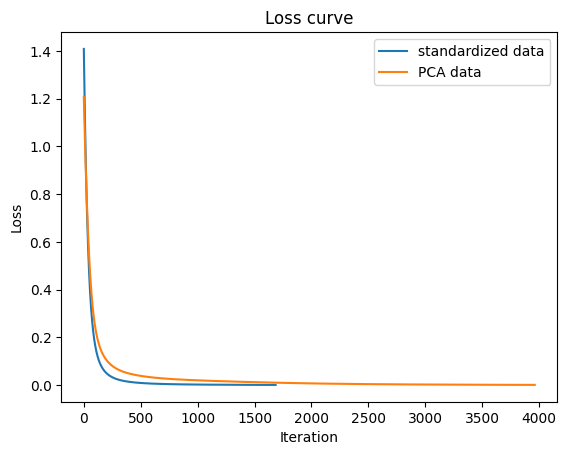

In [117]:
plt.plot(clf_MLP_ori.loss_curve_, label = 'Standardized data')
plt.plot(clf_MLP_pca.loss_curve_, label = 'PCA data')
plt.xlabel('Iteration'), plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

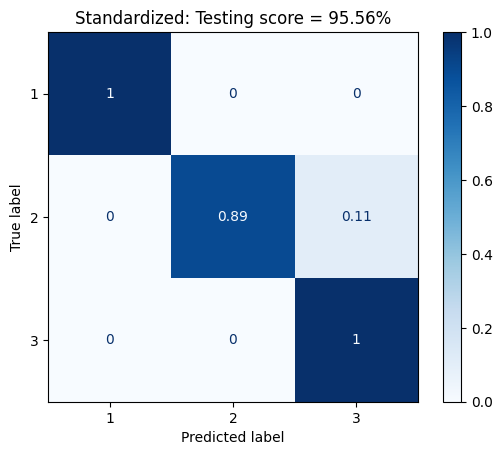

In [122]:
score = 100*clf_MLP_ori.score(X_test_, y_test)
title = 'Standardized: Testing score = {:.2f}%'.format(score)
disp = ConfusionMatrixDisplay.from_estimator(
    clf_MLP_ori,
    X_test_, y_test,
    cmap = plt.cm.Blues,
    normalize = 'true'
)
disp.ax_.set_title(title)
plt.show()


【上圖】只有第二間酒廠的酒會被錯分成第三間酒廠，其餘兩間都能準確地被分類。 <br>
【下圖】同樣只有第二間酒廠的酒會錯分成另外兩間。

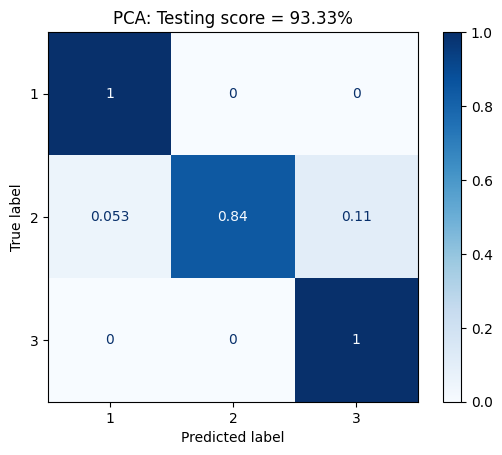

In [121]:
score = 100*clf_MLP_pca.score(Z_test, y_test)
title = 'PCA: Testing score = {:.2f}%'.format(score)
disp = ConfusionMatrixDisplay.from_estimator(
    clf_MLP_pca,
    Z_test, y_test,
    cmap = plt.cm.Blues,
    normalize = 'true'
)
disp.ax_.set_title(title)
plt.show()


【結論】

根據上面執行的結果顯示，不論是用羅吉斯迴歸、SVM 或是神經網路，使用標準化資料所訓練的學習器所得分類結果較佳，但此資料很小，計算起來與 PCA 資料所需的時間差距不大，在較高的準確率下，可以使用原始資料訓練就好。另外，從 Loss Curve 可以看到，雖然原始資料起初的 Loss 較高，但收斂速度較快，迭代次數將近 PCA 資料的一半，更能確定使用原始標準化資料的效果會比主成分資料來的佳。

使用 GridSearchCV 與 RandomizedSearchCV 所得的最佳參數組合，預測出的準確率差不多，甚至較高，Grid 的方式不僅耗時，獲取的結果也不一定是最佳模型，所以使用 RandomizedSearchCV 的參數組合不僅能節省時間，還能得到相似的準確率。